In [4]:
from src.elpv.utils.elpv_reader import load_dataset
import numpy as np
import matplotlib as plt
import cv2

from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

import cv2 as cv
# from PIL import Image
import matplotlib.pyplot as plt

In [5]:
images, probs, types = load_dataset()

In [3]:
# OTSU IMAGE SEGMENTATION HUEHUEHUE
# uncomment below code for otsu segmentation

# for i in range(0, len(images)):
#     retOtsu,thOtsu = cv2.threshold(images[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     images[i] = thOtsu

In [6]:
# MAKE BIG TRAINING AND TESTING SET
# reshape images
images1d = images.copy()
images1d = np.reshape(images1d, (len(images), 300 * 300))

# setup probs array to be discrete values
probs_discrete = np.zeros(len(probs))
probs_discrete[probs == 0.0] = 1
probs_discrete[probs == 1/3] = 2
probs_discrete[probs == 2/3] = 3
probs_discrete[probs == 1] = 4

# join arrays into array of tuples
labels = []
for i in range(0, len(probs_discrete)):
    labels.append((types[i], probs_discrete[i]))

# split into test and train
x_train, x_test, y_train, y_test = train_test_split(images1d, labels, test_size=0.25, random_state=50)

# further split y axis (labels) back into types and probs
y_train_monopoly = np.ones(len(y_train), dtype='object')
y_train_probs = np.ones(len(y_train))
for i in range(0, len(y_train)):
    y_train_monopoly[i] = y_train[i][0]
    y_train_probs[i] = y_train[i][1]

x_train_mono        = x_train[y_train_monopoly == "mono"]
y_train_probs_mono  = y_train_probs[y_train_monopoly == "mono"]

x_train_poly        = x_train[y_train_monopoly == "poly"]
y_train_probs_poly  = y_train_probs[y_train_monopoly == "poly"]


y_test_monopoly = np.ones(len(y_test), dtype='object')
y_test_probs = np.ones(len(y_test))
for i in range(0, len(y_test)):
    y_test_monopoly[i] = y_test[i][0]
    y_test_probs[i] = y_test[i][1]

# print(y_train_monopoly)
# print(y_train_probs)
# print(y_test_monopoly)
# print(y_test_probs)

# TRAIN (fit) MODELS!
#   classify into mono and poly:
neighMonoPoly = KNeighborsClassifier(n_neighbors=3)
neighMonoPoly.fit(x_train, y_train_monopoly)

#   classify probabilities for mono:
neighProbsMono = KNeighborsClassifier(n_neighbors=3)
neighProbsMono.fit(x_train_mono, y_train_probs_mono)

#   classify probabilities for poly:
neighProbsPoly = KNeighborsClassifier(n_neighbors=3)
neighProbsPoly.fit(x_train_poly, y_train_probs_poly)




KNeighborsClassifier(n_neighbors=3)

In [7]:
# Testing

# first split into mono- and poly- type panels
predictMonoPoly = neighMonoPoly.predict(x_test)

assumed_mono_images = x_test[predictMonoPoly == "mono"]
assumed_poly_images = x_test[predictMonoPoly == "poly"]

# then, classify based on each type
predictMono = neighProbsMono.predict(assumed_mono_images)
predictPoly = neighProbsPoly.predict(assumed_poly_images)

# regroup
predictAll = np.ones(len(predictMono) + len(predictPoly))
predictAll[predictMonoPoly == "mono"] = predictMono
predictAll[predictMonoPoly == "poly"] = predictPoly

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test_probs, predictAll))

              precision    recall  f1-score   support

         1.0       0.68      0.89      0.77       358
         2.0       0.52      0.35      0.42        75
         3.0       0.25      0.03      0.06        29
         4.0       0.77      0.52      0.62       194

    accuracy                           0.68       656
   macro avg       0.55      0.45      0.47       656
weighted avg       0.67      0.68      0.65       656



Text(0, 0.5, 'True Label')

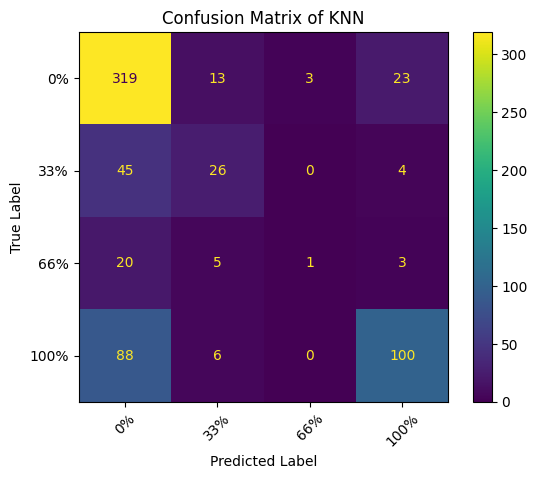

In [11]:
cf_matrix = confusion_matrix(y_test_probs, predictAll)
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=["0%", "33%", "66%", "100%"])
disp.plot(xticks_rotation=45, cmap="viridis")
plt.title('Confusion Matrix of KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')